# Applied Data Science Capstone Project
This notebook documents the tasks required for the Coursera "IBM Data Science Professional Certificate" specialisation capstone. It is subdivided into the tasks according to the five weeks of project duration. 


## Week 1: Creating the assignment notebook and a GitHub project
Import libraries.

In [10]:
import pandas as pd
import numpy as np
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Week 2
No assignments during this week. Let's use this space to save the Foursquare credentials. 


In [43]:
# @hidden
CLIENT_ID = 'MUQZABRY5SR2BN5BHN34QIZZFEINQ14UUNEBECF0N10HS4YAB' # your Foursquare ID, this is only an example that doesn't work
CLIENT_SECRET = 'NVSUKVIBHZCXLIT51R3U434X5OCDK1KTKXV5H1ERZ3COBY0NB' # your Foursquare Secret, this is only an example that doesn't work
VERSION = '20180605' # Foursquare API version, this is only an example that doesn't work

## Week 3: Analysis and clustering of Toronto neighborhoods based on Foursquare venue data

### Part 1 - Load Toronto Borough and Neighborhood Names from Wikipedia, and clean dataframe

For this assignment, we will explore and cluster the neighborhoods in Toronto. To do this we will scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe. The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood. 

We only process cells that have an assigned borough and ignore cells with a borough that is "Not assigned". For postal codes with more than one neighnorhood, we will combine the neighborhoods and separate them with a comma. For cells that have a borough but a "Not assigned" neighborhood, the neighborhood will be named the same as the borough.

Let's import urllib request and BeautifulSoup libraries first, which enables us to retrieve web documents and text scraping of these documents.

In [12]:
from urllib import request
from bs4 import BeautifulSoup

We specify the url where the zip codes are present, load the html file from that url and parse the file to extract its information in string format. BeautifulSoup automagically categorises the information based on the html tags, here, we print the title of the html page as means of verification. Moreover, since BeautifulSoup conveniently separates all tags, we can peek into what it found for "table".

In [13]:
zip_codes_url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
zip_codes_html=request.urlopen(zip_codes_url)
zip_codes_soup = BeautifulSoup(zip_codes_html, 'html.parser')

print('The title tag of the imported HTML is:\n\n' + zip_codes_soup.title.prettify() + '\n')
print('The the headers and first row of the HTML table is:\n\n' + zip_codes_soup.table.prettify()[:265])

The title tag of the imported HTML is:

<title>
 List of postal codes of Canada: M - Wikipedia
</title>


The the headers and first row of the HTML table is:

<table class="wikitable sortable">
 <tbody>
  <tr>
   <th>
    Postal Code
   </th>
   <th>
    Borough
   </th>
   <th>
    Neighborhood
   </th>
  </tr>
  <tr>
   <td>
    M1A
   </td>
   <td>
    Not assigned
   </td>
   <td>
    Not assigned
   </td>
  </tr>
  


Pandas can read HTML strings and convert containing tables into dataframes, here we convert the first (and only) table, indicated by the trailing [0]. As an option of pandas' "read_html" method (or any of pandas' "read_*" methods), we can indicate how missing values are treated in the original table. 

In our table, they are present in form of "Not assigned". We flag "Not assigned" values and convert them to "NaN". Then, we drop all rows where no "Boroughs" have been assigned to the postal code, and assign the Borough name to Neighborhood for the case that a Neighborhood is not assigned (but a Borough is). Lastly, the index is reset. We now have the cleaned dataframe.

In [14]:
df_zip = pd.read_html(str(zip_codes_soup.table),na_values='Not assigned')[0].dropna(axis=0,subset=['Borough'])
df_zip[df_zip['Neighborhood'].isna()].iloc[:][2]=df_zip[df_zip['Neighborhood'].isna()].Borough
df_zip.reset_index(inplace=True,drop=True)

Let's check the dataframe's statistics and peek into the first few entries.

In [15]:
print('\n Dataframe shape: ' + str(df_zip.shape))
print('\n Dataframe details by "describe" method:\n')
print(df_zip.describe())
print('\n First 12 entries of the cleaned dataframe:\n')
df_zip.head(12)


 Dataframe shape: (103, 3)

 Dataframe details by "describe" method:

       Postal Code     Borough Neighborhood
count          103         103          103
unique         103          10           99
top            M5V  North York    Downsview
freq             1          24            4

 First 12 entries of the cleaned dataframe:



,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


We find that there are 103 unique Postal codes with Boroughs assigned. Within these postal codes, we find 10 unique Boroughs and 99 unique Neighborhood combinations. The Borough "North York" and the Neighborhood "Downsview" are assigned to the most postal codes, with 24 and 4 assignments, respectively. Note, however, that this analysis does not take into account that there might be more duplicates or more unique neighborhoods within the string in any row of the Neighborhood column. We will be addressing this in part 3, because it is out of the scope of this part of the assignment.

### Part 2 - Adding Coordinates to the data frame

Now that we have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

We could use Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood, but recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, therefore we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

In [16]:
!pip install geocoder
import geocoder # import geocoder

The problem with this Package is that we have to be persistent in order to get the geographical coordinates of a given postal code. Sometimes, when we make a call to get the latitude and longitude coordinates of a given postal code, the result would be None, and then on another call we would get the coordinates. So, in order to make sure that we get the coordinates for all of our neighborhoods, we run a while loop for each postal code. 

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

In [17]:
# extract first zip code: "M3A"
Example_Zip=df_zip.iloc[0,0]
# initialise loop parameters
lat_lng_coords=None
it=0
searching=True
# searching for coordinates until we find them or until we tried 100 times
while (lat_lng_coords is None)&(searching):
    g = geocoder.google('{}, Toronto, Ontario'.format(Example_Zip))
    lat_lng_coords = g.latlng
    it=it+1
    if it>=100:
        searching=False
# if we reach 100 trials, 'searching' will be False otherwise it will be True, therefore, let's call it 'succeeded' from now on
succeeded=searching
if succeeded:
    # in case we found the coordinates for the first example, chances are good that we can get them for the entire data set, hence we loop 
    # through the dataframe.
    print("Found Coordinates for '{}': {}, {}; Continue to look for remaining data.".format('{}, Toronto, Ontario'.format(Example_Zip),lat_lng_coords[0],lat_lng_coords[1]))
    for ii in range(len(len(df_zip))):
        lat_lng_coords=None
        latitude=np.zeros(len(df_zip))
        longitude=np.zeros(len(df_zip))
        while (lat_lng_coords is None):
            g = geocoder.google('{}, Toronto, Ontario'.format(df_zip.iloc[ii,0]))
            lat_lng_coords = g.latlng
        latitude[ii] = lat_lng_coords[0]
        longitude[ii] = lat_lng_coords[1]
    # copy the coordinates into the data frame
    df_zip['Latitude']=latitude
    df_zip['Longitude']=longitude
else:
    # in case we were not successful in finding the coordinates for the first postal code with 100 attempts, we have to assume that the 
    # library does not perform and we resort to import the prepared CSV file and merge the content with our data frame.
    print("Could not find Coordinates for '{}' after {} trials. Unable to retrieve Coordinates with 'geocoder'. Load prepared file.".format('{}, Toronto, Ontario'.format(Example_Zip),it))
    coord=pd.read_csv('http://cocl.us/Geospatial_data')
    df_zip=pd.merge(df_zip,coord,on="Postal Code")
# 
df_zip.head(12)
    

Could not find Coordinates for 'M3A, Toronto, Ontario' after 100 trials. Unable to retrieve Coordinates with 'geocoder'. Load prepared file.


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


We tried to use 'geocoder' 100 times for the first postal code and it did not result in valid coordinates. Hence, we judge that the library is not working (anymore?) and resort to load the prepared CSV file with coordinates. Above, the obtained dataframe with coordinates has been joined with the previously prepared dataframe to produce the desired output.

### Part 3 - Exploring and clustering Toronto's neighborhoods

Let us explore and cluster the neighborhoods in Toronto. (We decided to work with only boroughs that contain the word Toronto.)

Before anything else, let us clean up our dataframe. The above dataframe has been presented such to conform with what is asked for the assignment but we don't feel that it is particularly useful for an analysis of the neighborhoods. In the given dataframe the postal codes are unique and the each postal code can contain several neighborhoods. Let's create a dataframe with unique neigborhoods, where the neighborhoods may extend over several postal codes. 

Here is what we do inside the argument of DataFrame to create a new dataframe with unique neigborhoods: First, we split the string in all Neighborhood cells in dataframe df_zip, second, we stack the new columns (from splitting the strings) to new rows; lastly we rename the resulting column and reset the index.

Afterwards, we can merge the new with the old dataframe with the original index as key. Lastly, we use the Neighborhood as index and group Postal codes and Boroughs by Neigborhoods.

In [89]:
# dataframe with unique neighborhoods and indices corresponding to the previous dataframe
df_neigh=pd.DataFrame(df_zip['Neighborhood'] \
                            .apply(lambda x: pd.Series(map(str.strip,x.split(', ')))) \
#                            .apply(lambda x: pd.Series(x.split(', '))) \
                            .stack() \
                            .rename('Neighborhood') \
                            .reset_index(level=1, drop=True)).reset_index()
print('\n Dataframe with unique neighborhoods and indices corresponding to the previous dataframe:\n')
print(df_neigh.head(12))
# extract postal codes and boroughs from previous dataframe and merge with new one based on original index
df_temp=df_zip[['Postal Code','Borough']].reset_index()
df_neigh=pd.merge(df_neigh,df_temp,on='index')
df_uniq_neigh=pd.DataFrame(df_neigh.groupby(['Neighborhood'])['Postal Code'].apply(lambda x: "%s" % ', '.join(list(set(x)))))
df_uniq_neigh['Borough']=pd.DataFrame(df_neigh.groupby(['Neighborhood'])['Borough'].apply(lambda x: "%s" % ', '.join(list(set(x)))))
print('\n Dataframe with {} unique neighborhoods with their respective postal codes and boroughs from the previous dataframe:\n'.format(len(df_uniq_neigh)))
df_uniq_neigh.head(12)


 Dataframe with unique neighborhoods and indices corresponding to the previous dataframe:

    index                   Neighborhood
0       0                      Parkwoods
1       1               Victoria Village
2       2                    Regent Park
3       2                   Harbourfront
4       3                 Lawrence Manor
5       3               Lawrence Heights
6       4                   Queen's Park
7       4  Ontario Provincial Government
8       5               Islington Avenue
9       5          Humber Valley Village
10      6                        Malvern
11      6                          Rouge

 Dataframe with 208 unique neighborhoods with their respective postal codes and boroughs from the previous dataframe:



,Postal Code,Borough
Neighborhood,,
Adelaide,M5H,Downtown Toronto
Agincourt,M1S,Scarborough
Agincourt North,M1V,Scarborough
Albion Gardens,M9V,Etobicoke
Alderwood,M8W,Etobicoke
Bathurst Manor,M3H,North York
Bathurst Quay,M5V,Downtown Toronto
Bayview Village,M2K,North York
Beaumond Heights,M9V,Etobicoke


Now, let's add the coordinates to the dataframe using the "geopy" library. For this we need to install Geopy and load the library first.

In [19]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0           conda-forge
    geopy:          

Here we request the location data of all neighborhoods from Geopy. It may be possible that Geopy does not recognise a neighborhood, in that case we request the location of the borough. Should the borough request not yield location information we request the location of the post code as a last resort. Location information is added to the dataframe. 

Note, that it appears that calls to Geopy are limited in number during a specific time, therefore we may need to iterate several times through the Geopy call as there can be denied requests.

In [90]:
import time

city = 'Toronto, ON'
if 'Latitude' not in df_uniq_neigh.columns:
    df_uniq_neigh['Latitude']=np.nan
if 'Longitude' not in df_uniq_neigh.columns:
    df_uniq_neigh['Longitude']=np.nan
geolocator = Nominatim(user_agent="geo_explorer")

while np.isnan(df_uniq_neigh.loc[df_uniq_neigh.index[-1],'Latitude']):
    for neigh in list(df_uniq_neigh.index.values):
        try:
            if np.isnan(df_uniq_neigh.loc[neigh,'Latitude']):
                location = geolocator.geocode(neigh+', '+city)
                if location==None:
                    location = geolocator.geocode(df_uniq_neigh.loc[neigh,'Borough']+', '+city)
                    if location==None:
                        location = geolocator.geocode(df_uniq_neigh.loc[neigh,'Post Code']+', '+city)
                latitude = location.latitude
                longitude = location.longitude
                df_uniq_neigh.loc[neigh,'Latitude']=latitude
                df_uniq_neigh.loc[neigh,'Longitude']=longitude
        except:
            print("Request denied! Let's try again after one second.")
            time.sleep(1)
            break
df_uniq_neigh.reset_index(inplace=True)
df_uniq_neigh.tail()

,Neighborhood,Postal Code,Borough,Latitude,Longitude
203,Woodbine Heights,M4C,East York,43.699930,-79.319132
204,York Mills,M2L,North York,43.744039,-79.406657
205,York Mills West,M2P,North York,43.744039,-79.406657
206,York University,M3J,North York,43.779242,-79.483559
207,Yorkville,M5R,Central Toronto,43.671386,-79.390168


Now, we have a new dataframe with all unique neighborhoods in Toronto, ON, with their (more accurate) location information. 

Let us proceed to obtain location data for the neighborhoods from FourSquare. To do this, let's borrow a function from a previous lab that obtains venues from FourSquare.

In [92]:
# function that returns nearby venues for 500m around the center of a neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            results=[]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    try:
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    except:
        pass
    
    return(nearby_venues)

Here we obtain venues in all Toronto neighborhoods available from the Foursquare data base.

In [93]:
toronto_venues = getNearbyVenues(names=df_uniq_neigh['Neighborhood'],
                                   latitudes=df_uniq_neigh['Latitude'],
                                   longitudes=df_uniq_neigh['Longitude']
                                  )

Adelaide
Agincourt
Agincourt North
Albion Gardens
Alderwood
Bathurst Manor
Bathurst Quay
Bayview Village
Beaumond Heights
Bedford Park
Berczy Park
Birch Cliff
Bloordale Gardens
Broadview North (Old East York)
Brockton
Business reply mail Processing Centre
CN Tower
Cabbagetown
Caledonia-Fairbanks
Canada Post Gateway Processing Centre
Cedarbrae
Central Bay Street
Chinatown
Christie
Church and Wellesley
Clairlea
Clarks Corners
Cliffcrest
Cliffside
Cliffside West
Cloverdale
Commerce Court
Davisville
Davisville North
Deer Park
Del Ray
Design Exchange
Don Mills
Dorset Park
Dovercourt Village
Downsview
Downsview North
Dufferin
East Birchmount Park
East Toronto
Emery
Eringate
Exhibition Place
Fairview
First Canadian Place
Forest Hill North & West
Forest Hill Road Park
Forest Hill SE
Garden District
Glencairn
Golden Mile
Grange Park
Guildwood
Harbord
Harbourfront
Harbourfront East
Harbourfront West
Henry Farm
High Park
Highland Creek
Hillcrest Village
Humber Bay
Humber Bay Shores
Humber Summit


In [127]:
print("We have found {} venues in our neighborhoods with {} unique categories.".format(toronto_venues.shape[0],len(toronto_venues['Venue Category'].unique())))
toronto_venues.head()

We have found 6123 venues in our neighborhoods with 337 unique categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adelaide,43.650298,-79.380477,Richmond Station,43.651569,-79.379266,American Restaurant
1,Adelaide,43.650298,-79.380477,Adelaide Club Toronto,43.649279,-79.381921,Gym / Fitness Center
2,Adelaide,43.650298,-79.380477,Brick Street Bakery,43.648815,-79.380605,Bakery
3,Adelaide,43.650298,-79.380477,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop
4,Adelaide,43.650298,-79.380477,John & Sons Oyster House,43.650656,-79.381613,Seafood Restaurant


We transform all categories into a one-hot scheme, so that each category appears as one column, and each venue has exactly one '1' at the column that corresponds to its category. Then, we group rows by neighborhood and take the mean of the frequency of occurrence of each category.

In [128]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot.index = toronto_venues['Neighborhood'] 
toronto_onehot.index.name='Neighborhood Name'
toronto_onehot.reset_index(inplace=True)

toronto_grouped = toronto_onehot.groupby('Neighborhood Name').mean().reset_index()
toronto_grouped

print(toronto_grouped.shape)
toronto_grouped.head()

(207, 338)


,Neighborhood Name,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Adelaide,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.01,0.0,0.0,0.000000,0.0,0.0,0.01,0.000000,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.071429,0.0,0.0,0.00,0.000000,0.00,0.0
2,Agincourt North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.037037,0.0,0.0,0.00,0.037037,0.00,0.0
3,Albion Gardens,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.00,0.0
4,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.00,0.0


The first 10 neighborhoods along with the top 5 most common venues:

In [129]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood Name'].iloc[:10]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
                 venue  freq
0                 Café  0.07
1          Coffee Shop  0.07
2                  Gym  0.05
3  Japanese Restaurant  0.05
4           Restaurant  0.05


----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.21
1            Restaurant  0.07
2  Hong Kong Restaurant  0.07
3           Coffee Shop  0.07
4         Shopping Mall  0.07


----Agincourt North----
                 venue  freq
0                 Bank  0.07
1   Chinese Restaurant  0.07
2               Bakery  0.07
3    Convenience Store  0.04
4  Sporting Goods Shop  0.04


----Albion Gardens----
                  venue  freq
0         Grocery Store  0.17
1        Hardware Store  0.08
2            Beer Store  0.08
3  Fast Food Restaurant  0.08
4   Fried Chicken Joint  0.08


----Alderwood----
          venue  freq
0   Pizza Place   0.2
1          Pool   0.1
2  Dance Studio   0.1
3           Gym   0.1
4           Pub   0.1


----Bathurst Manor----
               venue  freq


We take advantage of a function from a previous lab. The function sorts categories by their frequency for each neighborhood. 

In [130]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [135]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood Name'] = toronto_grouped['Neighborhood Name']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Restaurant,Gym,Japanese Restaurant,Italian Restaurant,Hotel,Clothing Store,Gastropub,American Restaurant
1,Agincourt,Chinese Restaurant,Peking Duck Restaurant,Cantonese Restaurant,Restaurant,Asian Restaurant,Korean Restaurant,Coffee Shop,Train Station,Shopping Mall,Vietnamese Restaurant
2,Agincourt North,Bank,Chinese Restaurant,Bakery,Fast Food Restaurant,Liquor Store,Beer Store,Sporting Goods Shop,Pharmacy,Fried Chicken Joint,Movie Theater
3,Albion Gardens,Grocery Store,Fried Chicken Joint,Hardware Store,Fast Food Restaurant,Beer Store,Caribbean Restaurant,Liquor Store,Gym Pool,Sandwich Place,Pizza Place
4,Alderwood,Pizza Place,Pharmacy,Skating Rink,Sandwich Place,Coffee Shop,Dance Studio,Pub,Gym,Pool,Cupcake Shop


Run k-means to cluster the neighborhoods into 5 clusters.

In [254]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # can be reset with: "neighborhoods_venues_sorted.drop('Cluster Labels',axis=1,inplace=True)"

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 4, 0, 4, 3, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [255]:


toronto_merged = df_uniq_neigh

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood Name'), on='Neighborhood')

# keep cluster index as Integer
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype('Int64')
# drop NaNs
toronto_merged.dropna(inplace=True)
# reset index after removing NaN
toronto_merged.reset_index(inplace=True,drop=True) 
toronto_merged.head() 

,Neighborhood,Postal Code,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,M5H,Downtown Toronto,43.650298,-79.380477,3,Coffee Shop,Café,Restaurant,Gym,Japanese Restaurant,Italian Restaurant,Hotel,Clothing Store,Gastropub,American Restaurant
1,Agincourt,M1S,Scarborough,43.785353,-79.278549,3,Chinese Restaurant,Peking Duck Restaurant,Cantonese Restaurant,Restaurant,Asian Restaurant,Korean Restaurant,Coffee Shop,Train Station,Shopping Mall,Vietnamese Restaurant
2,Agincourt North,M1V,Scarborough,43.808038,-79.266439,3,Bank,Chinese Restaurant,Bakery,Fast Food Restaurant,Liquor Store,Beer Store,Sporting Goods Shop,Pharmacy,Fried Chicken Joint,Movie Theater
3,Albion Gardens,M9V,Etobicoke,43.741665,-79.584543,3,Grocery Store,Fried Chicken Joint,Hardware Store,Fast Food Restaurant,Beer Store,Caribbean Restaurant,Liquor Store,Gym Pool,Sandwich Place,Pizza Place
4,Alderwood,M8W,Etobicoke,43.601717,-79.545232,4,Pizza Place,Pharmacy,Skating Rink,Sandwich Place,Coffee Shop,Dance Studio,Pub,Gym,Pool,Cupcake Shop


We need to install Folium for nice map plots. This may take a while.

In [208]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
import matplotlib.cm as cm
import matplotlib.colors as colors
from itertools import chain

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

    altair:  4.1.0-py_1 conda-forge
    branca:  0.4.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


altair-4.1.0         | 614 KB    | ##################################### | 1

Finally, let's visualize the resulting clusters on the map of Toronto.

In [256]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="geo_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Install word cloud in order to make it easier to distuinguish which venues are dominant in the clusters.

In [257]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
from itertools import chain

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [330]:
stopwords = set(STOPWORDS)
stopwords.update(('Store','Shop','Place','Station','Space','Restaurant'))
stopwords.discard("park")
toronto_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

We define a function, that helps us to extract the venue categories from the dataframe and distill all categories present in one cluster into a string. Later we can use this string to paint a word cloud in order to visualise which categories are dominant in the present cluster.

In [331]:
def return_venue_str(df,cluster_idx):
    temp=df.drop(columns=['Neighborhood','Latitude','Longitude','Borough','Postal Code'])
    temp=temp.loc[temp['Cluster Labels'] == cluster_idx, temp.columns[[1] + list(range(5, temp.shape[1]))]].values.tolist()
    temp=list(chain(*temp))
    temp=" ".join(temp)
    return(temp)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot') # optional: for ggplot-like style

#### Cluster 1

The first cluster contains the following venues. The bigger the words are, the more frequently the venue is present in the neighborhoods of this cluster.

In [332]:
# generate list of values in dataframe
toronto_cluster1=return_venue_str(df=toronto_merged,cluster_idx=0)

# generate the word cloud
toronto_wc.generate(toronto_cluster1)


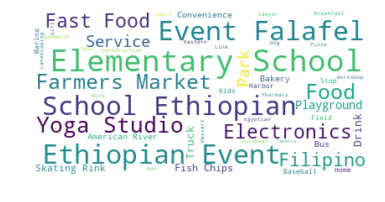

In [333]:
# display the word cloud
plt.imshow(toronto_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Based on the word cloud we would call this set of neighborhoods: "Quiet Family". The following neighborhoods are in this cluster:

In [347]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Bathurst Manor,0,Playground,Convenience Store,Baseball Field,Park,Filipino Restaurant,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market
52,Forest Hill SE,0,Playground,Bank,Park,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market
62,Henry Farm,0,Tennis Court,Park,Restaurant,Yoga Studio,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant
64,Highland Creek,0,IT Services,Park,Pharmacy,Neighborhood,Fast Food Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant
66,Humber Bay,0,Breakfast Spot,Pool,Construction & Landscaping,Deli / Bodega,Auto Workshop,Harbor / Marina,Park,Yoga Studio,Fast Food Restaurant,Elementary School
68,Humber Summit,0,Park,Bakery,Construction & Landscaping,Gym,Gift Shop,Yoga Studio,Filipino Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
69,Humber Valley Village,0,Convenience Store,Skating Rink,Bakery,Park,Bus Stop,Food & Drink Shop,Farmers Market,Elementary School,Food Truck,Ethiopian Restaurant
71,Humberlea,0,Convenience Store,Bakery,Gas Station,Food Service,Baseball Field,Yoga Studio,Fish & Chips Shop,Event Space,Falafel Restaurant,Farmers Market
74,Ionview,0,Construction & Landscaping,Metro Station,Deli / Bodega,Park,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant
84,King's Mill Park,0,Park,Playground,Spa,Metro Station,Event Space,American Restaurant,River,Fast Food Restaurant,Electronics Store,Elementary School


#### Cluster 2
The second cluster contains the following venues. The bigger the words are, the more frequently the venue is present in the neighborhoods of this cluster.

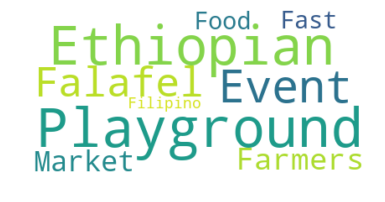

In [348]:
# generate list of values in dataframe
toronto_cluster2=return_venue_str(df=toronto_merged,cluster_idx=1)

# generate the word cloud
toronto_wc.generate(toronto_cluster2)

# display the word cloud
plt.imshow(toronto_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

There are only three neighborhoods in this cluster, which all have the same venues. We would classify it as an outlier and disregard it.

In [349]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
155,South Steeles,1,Playground,Fish & Chips Shop,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
159,Steeles East,1,Playground,Fish & Chips Shop,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
160,Steeles West,1,Playground,Fish & Chips Shop,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant


#### Cluster 3
The third cluster contains the following venues. The bigger the words are, the more frequently the venue is present in the neighborhoods of this cluster.

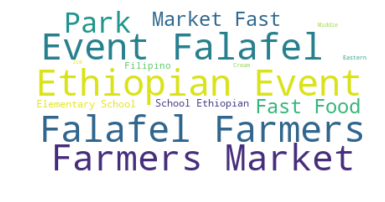

In [350]:
# generate list of values in dataframe
toronto_cluster3=return_venue_str(df=toronto_merged,cluster_idx=2)

# generate the word cloud
toronto_wc.generate(toronto_cluster3)

# display the word cloud
plt.imshow(toronto_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Based on the word cloud we would call this set of neighborhoods: "Quiet Living for Singles". The following neighborhoods are in this cluster:

In [351]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Clarks Corners,2,Park,Gas Station,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
46,Eringate,2,Park,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
85,Kingsview Village,2,Ice Cream Shop,Park,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
118,Northwood Park,2,Park,Baseball Field,Yoga Studio,Egyptian Restaurant,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
129,Port Union,2,Park,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
135,Richmond,2,Park,Beer Store,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
141,Rouge,2,Park,Fast Food Restaurant,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Filipino Restaurant
150,Silver Hills,2,Middle Eastern Restaurant,Park,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
186,Upper Rouge,2,Park,Fast Food Restaurant,Yoga Studio,Fish & Chips Shop,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Filipino Restaurant


#### Cluster 4
The fourth cluster contains the following venues. The bigger the words are, the more frequently the venue is present in the neighborhoods of this cluster.

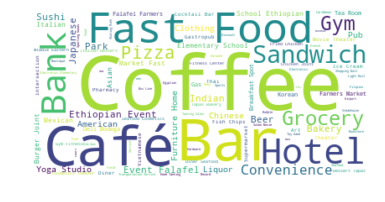

In [352]:
# generate list of values in dataframe
toronto_cluster4=return_venue_str(df=toronto_merged,cluster_idx=3)

# generate the word cloud
toronto_wc.generate(toronto_cluster4)

# display the word cloud
plt.imshow(toronto_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Based on the word cloud we would call this set of neighborhoods: "Metropolitan Single". The following neighborhoods are in this cluster:

In [353]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,3,Coffee Shop,Café,Restaurant,Gym,Japanese Restaurant,Italian Restaurant,Hotel,Clothing Store,Gastropub,American Restaurant
1,Agincourt,3,Chinese Restaurant,Peking Duck Restaurant,Cantonese Restaurant,Restaurant,Asian Restaurant,Korean Restaurant,Coffee Shop,Train Station,Shopping Mall,Vietnamese Restaurant
2,Agincourt North,3,Bank,Chinese Restaurant,Bakery,Fast Food Restaurant,Liquor Store,Beer Store,Sporting Goods Shop,Pharmacy,Fried Chicken Joint,Movie Theater
3,Albion Gardens,3,Grocery Store,Fried Chicken Joint,Hardware Store,Fast Food Restaurant,Beer Store,Caribbean Restaurant,Liquor Store,Gym Pool,Sandwich Place,Pizza Place
7,Bayview Village,3,Bank,Sporting Goods Shop,Outdoor Supply Store,Breakfast Spot,Bubble Tea Shop,Burger Joint,Gas Station,Fish Market,Fast Food Restaurant,Sandwich Place
8,Beaumond Heights,3,Convenience Store,Farmers Market,Clothing Store,Coffee Shop,Restaurant,Café,Transportation Service,Grocery Store,Hotel,Intersection
9,Bedford Park,3,Rental Car Location,Construction & Landscaping,Fish & Chips Shop,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant
10,Berczy Park,3,Coffee Shop,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Breakfast Spot,Cocktail Bar,Beer Bar,Gastropub,Bakery
11,Birch Cliff,3,Café,Skating Rink,General Entertainment,College Stadium,Yoga Studio,Filipino Restaurant,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant
12,Bloordale Gardens,3,Convenience Store,Intersection,Shipping Store,Bank,Donut Shop,Coffee Shop,Sandwich Place,Deli / Bodega,Cuban Restaurant,Creperie


#### Cluster 5
The fifth cluster contains the following venues. The bigger the words are, the more frequently the venue is present in the neighborhoods of this cluster.

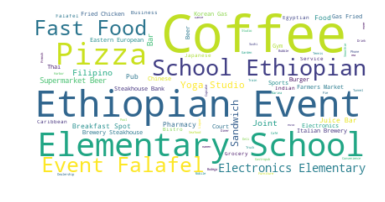

In [354]:
# generate list of values in dataframe
toronto_cluster5=return_venue_str(df=toronto_merged,cluster_idx=4)

# generate the word cloud
toronto_wc.generate(toronto_cluster5)

# display the word cloud
plt.imshow(toronto_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Based on the word cloud we would call this set of neighborhoods: "Metropolitan Family". The following neighborhoods are in this cluster:

In [355]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,M8W,4,Pizza Place,Pharmacy,Skating Rink,Sandwich Place,Coffee Shop,Dance Studio,Pub,Gym,Pool,Cupcake Shop
6,M5V,4,Coffee Shop,Café,Park,Caribbean Restaurant,Harbor / Marina,Ramen Restaurant,Japanese Restaurant,Tunnel,Diner,Garden
15,M7Y,4,Juice Bar,Food Court,Park,Coffee Shop,Restaurant,Yoga Studio,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space
18,M6E,4,Pizza Place,Park,Construction & Landscaping,Asian Restaurant,Coffee Shop,Supermarket,Beer Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
28,M1M,4,Pizza Place,Pub,Grocery Store,Auto Workshop,Coffee Shop,Sandwich Place,Breakfast Spot,Filipino Restaurant,Electronics Store,Elementary School
29,M1N,4,Pizza Place,Pub,Grocery Store,Auto Workshop,Coffee Shop,Sandwich Place,Breakfast Spot,Filipino Restaurant,Electronics Store,Elementary School
35,M6M,4,Pizza Place,Park,Construction & Landscaping,Asian Restaurant,Coffee Shop,Supermarket,Beer Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
44,M4J,4,Juice Bar,Food Court,Park,Coffee Shop,Restaurant,Yoga Studio,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space
59,M5A,4,Coffee Shop,Café,Restaurant,Hotel,Italian Restaurant,Brewery,Steakhouse,Bank,Pizza Place,Sports Bar
60,M5J,4,Coffee Shop,Café,Restaurant,Hotel,Italian Restaurant,Brewery,Steakhouse,Bank,Pizza Place,Sports Bar


Let's summarise the names we gave to the different clusters:

| Cluster   | Name                |
|-----------|---------------------|
|     1     | Quiet Family        |
|     2     | discarded           |
|     3     | Quiet Single        |
|     4     | Metropolitan Single |
|     5     | Metropolitan Family |